In [1]:
import numpy as np
from numba import jit
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Define functions for GPR forward model

In [2]:
def GPR_forward_matrix(sources, boreholes_distance):
    """
    Calculate matrix to compute GPR forward model
    
    We assume each source is located on the center of a layer,
    creating a discretized model of the subsurface based on
    layers of equal thickness.
    
    Parameters
    ----------
    sources : array
        Depth to sources and receivers. Each pair of sources
        and receivers are assumed to be located at the same depths.
    boreholes_distance : float
        Horizontal distance between sources and receivers
        boreholes.
        
    Returns
    -------
    G : numpy.matrix
        Matrix for forward modelling.
    """
    # Get number of sources
    n_sources = sources.size
    # Create receivers depths (they are the same as sources)
    receivers = sources.copy()
    # Compute equidistance between sources
    dh = sources[1] - sources[0]
    # Initialize matrix full of zeros
    G = np.matrix(np.zeros((n_sources ** 2, n_sources)))
    for i, source in enumerate(sources):
        for j, receiver in enumerate(receivers):
            height = abs(source - receiver)
            if i == j:
                # Source and receiver are on the same layer
                G[j + n_sources * i, i] = boreholes_distance
            else:
                # Source and receiver are on different layer
                factor = np.sqrt(1 + boreholes_distance ** 2 / height ** 2) * dh
                for k in range(n_sources):
                    kmin, kmax = min(i, j), max(i, j)
                    if k == kmin or k == kmax:
                        G[j + n_sources * i, k] = 0.5 * factor
                    elif k > kmin and k < kmax:
                        G[j + n_sources * i, k] = factor
    return G


@jit(nopython=True)
def forward(G, porosity):
    """
    Compute GPR forward model on four porosity layers
    
    We assume that four layers are present in the model,
    where the first and the third one has double the thickness of the
    others.
    So on the six layers model, we must set the same porosity values
    for layers 1 and 2, and 4 and 5.
    
    Parameters
    ----------
    G : numpy.matrix
        Forward modelling matrix.
    porosity : list or array
        Porosity values for each one of the four layers.

    Returns
    -------
    times : array
        Travel times between each source-receiver pair.
        For each receiver there are six arrival times, one
        for each source.
        So the `times` array has 36 elements.
    """
    # Convert the four porosities into 6 layers
    porosity_six_layers = np.zeros(6)
    porosity_six_layers[0] = porosity[0]
    porosity_six_layers[1] = porosity[0]
    porosity_six_layers[2] = porosity[1]
    porosity_six_layers[3] = porosity[2]
    porosity_six_layers[4] = porosity[2]
    porosity_six_layers[5] = porosity[3]
    # Convert porosity to slowness
    slowness = _porosity_to_slowness(porosity_six_layers)
    slowness = slowness.reshape(6, 1)
    # Compute arrival times on receivers
    times = np.dot(G, slowness)
    return times


@jit(nopython=True)
def _porosity_to_slowness(porosity, kappa_s=5, kappa_w=81):
    """
    Convert porosities to slowness
    
    It makes use of the CRIM equation under saturated conditions.
    
    Parameters
    ----------
    porosity : array
        Porosity values
    kappa_s : float (optional)
        Relative permitivity of grains
    kappa_w : float (optional)
        Relative permitivity of water
    """
    c = 0.3  # speed of light in vacumm in m/ns
    kappa_sqrt = (
        (1 - porosity) * np.sqrt(kappa_s)
        + porosity * np.sqrt(kappa_w)
    )
    slowness = kappa_sqrt / c
    return slowness

# Define functions for GPR inverse problem

In [3]:
@jit(nopython=True)
def inverse_problem(G, times, sigma, supremum, iterations, expected_acceptance=0.001):
    """
    Perform the GPR inverse problems
    
    It obtaines a collection of accepted porosity models based on the rejection
    sampling algorithm.
    
    Parameters
    ----------
    G : numpy.matrix
        Forward modelling matrix
    times : array
        Measured travel times on for every source-receiver pair
    sigma : float
        Standar deviation of the meassured times
    supremum : float
        Supremum value used on the rejection sampling algorithm.
        A high value will create more rejections, while a lower value will
        increase the acceptance ratio.
    iterations : int
        Number of total iterations
    expected_acceptance : float (optional)
        Pre-estimation of the acceptance ratio. It only serves to prevent
        high memory consumption. It doesn't interfere with the inversion.
        
    Returns
    -------
    accepted_porosities : array
        Set of accepted porosities models
    max_likelihood : float
        Maximum computed likelihood on every iteration
    """
    n_accepted = 0
    accepted_porosities = np.zeros((int(iterations * expected_acceptance), 4))
    max_likelihood = 0
    for i in range(iterations):
        # Draw a porosity array with uniform distribution between 0.2 and 0.4
        porosity = (0.4 - 0.2) * np.random.rand(4) + 0.2
        # Check if it should be rejected or accepted
        likelihood = _likelihood(G, porosity, times, sigma)
        if likelihood > max_likelihood:
            max_likelihood = likelihood
        probability = likelihood / supremum
        if np.random.rand() < probability:
            accepted_porosities[n_accepted] = porosity
            n_accepted += 1
    accepted_porosities = accepted_porosities[:n_accepted]
    return accepted_porosities, max_likelihood


@jit(nopython=True)
def _likelihood(G, porosity, times, sigma):
    """
    Compute likelihood of a porosity model
    """
    # Get number of data values
    n_times = times.size
    # Calculate the difference between predicted and data
    difference = np.linalg.norm(forward(G, porosity) - times)
    likelihood = (
        (1 / np.sqrt(2 * np.pi) / sigma) ** n_times
        * np.exp(-0.5 * difference ** 2 / sigma ** 2)
    )
    return likelihood

# Define function for plotting posteriors distributions

In [4]:
def plot_posterior(porosities, min_porosity=0.2, max_porosity=0.4):
    """
    Plot posterior distribution of each layer porosity
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6.66))
    for i, ax in enumerate(axes.ravel()):
        ax.hist(porosities[:, i])
        ax.set_title("Layer {}".format(i + 1))
        ax.set_xlim(min_porosity, max_porosity)

# Perform inversion of data from `data.mat`

## Define layers model and G matrix

We must define some variables regarding the layered model of the subsurface such as the distance between the sources and receivers boreholes and the depth to each GPR source.
We will work under the assumption that receivers and sources are respectively located at the same depths.

In [5]:
boreholes_distance = 4
sources = np.linspace(0.5, 5.5, 6)

Then, we will compute the forward modelling matrix, called **G**, in order to make future forward computations more efficient.

In [6]:
G = GPR_forward_matrix(sources, boreholes_distance)

## Read data from file

We will gather the data from the `data.mat` file. It contains ten datasets of travel times for each source-receiver pair.
We will work only with the fifth dataset.

In [7]:
data = loadmat("data.mat")
times = data["dataobs5"]
n_times = times.size
print("Number of travel time values: {}".format(n_times))

Number of travel time values: 36


## Perform inversions

We perform a first inversion by assuming a simple supremum $S_L$ defined as:

$$ S_L = \left( \frac{1}{\sqrt{2\pi} \sigma} \right)^N $$

Where $N=36$ is the number of data values (travel times).

We will run 35 million iterations in order to ensure a good sampling of the model space.

In [8]:
iterations = 35e6
sigma = 1
supremum = (1 / np.sqrt(2*np.pi) / sigma) ** n_times

porosities, max_likelihood = inverse_problem(
    G,
    times,
    sigma=sigma,
    supremum=supremum,
    iterations=iterations,
)

print("Supremum: {:1.2e}".format(supremum))
print("Accepted porosity models: {}".format(porosities.size))
print("Acceptance rate: {:f}".format(porosities.size / iterations))
print("Maximum likelihood: {:1.2e}".format(max_likelihood))

Supremum: 4.29e-15
Accepted porosity models: 0
Acceptance rate: 0.000000
Maximum likelihood: 4.22e-21


No model is accepted when running this inversion.
We must change the supremum value in order to increase the acceptance rate.

Lets try with a supremum defined as:

$$ S_L = \left( \frac{1}{\sqrt{2\pi} \sigma} \right)^N e^{-N/2} $$


In [9]:
iterations = 35e6
sigma = 1
supremum = (1 / np.sqrt(2*np.pi) / sigma) ** n_times * np.exp(-0.5 * n_times)

porosities, max_likelihood = inverse_problem(
    G,
    times,
    sigma=sigma,
    supremum=supremum,
    iterations=iterations,
)

print("Supremum: {:1.2e}".format(supremum))
print("Accepted porosity models: {}".format(porosities.size))
print("Acceptance rate: {:f}".format(porosities.size / iterations))
print("Maximum likelihood: {:1.2e}".format(max_likelihood))

Supremum: 6.54e-23
Accepted porosity models: 34588
Acceptance rate: 0.000988
Maximum likelihood: 4.27e-21


Lets plot the histogram of the porosity values of each layer

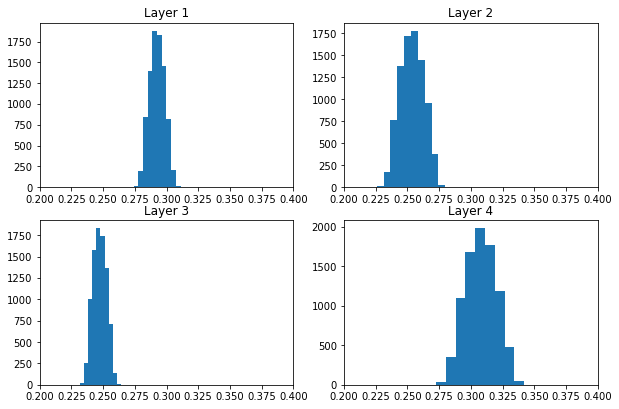

In [10]:
plot_posterior(porosities)
plt.show()

With this supremum value we get a significant number of accepted models and the posteriors distributions for each layer assembles Gaussian distributions.
Because layers 1 and 3 has two sources and two receivers, their posterior distributions are better defined.

We could try another value of the supremum as the maximum likelihood obtained on the previous run.

Supremum: 4.15e-21
Accepted porosity models: 2452
Acceptance rate: 0.000070
Maximum likelihood: 4.41e-21


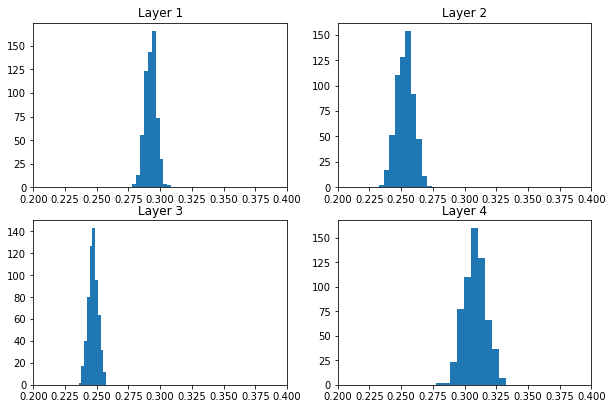

In [11]:
iterations = 35e6
sigma = 1
supremum = 4.15e-21

porosities, max_likelihood = inverse_problem(
    G,
    times,
    sigma=sigma,
    supremum=supremum,
    iterations=iterations,
)

print("Supremum: {:1.2e}".format(supremum))
print("Accepted porosity models: {}".format(porosities.size))
print("Acceptance rate: {:f}".format(porosities.size / iterations))
print("Maximum likelihood: {:1.2e}".format(max_likelihood))

plot_posterior(porosities)
plt.show()

Increasing the supremum we get even more defined posterior distributions, because we make the acceptance process more strict.